# Benchmarking


In [1]:
"""
Calculate PageRank on several random graphs.
"""
import scipy as sp
import pandas as pd
import numpy as np
import timeit
import sys
import random
import igraph
import networkx as nx

from src.pagerank import pagerank_power


def get_random_graph(
        min_size=20,
        max_size=2000,
        min_density=0.1,
        max_density=0.5):
    """
     Creates a random graph and a teleport vector and output them
        in different formats for different algorithms

    Inputs
    ------

    min_size and max_size: The size of the graph will be a random number
        in the range of (min_size, max_size)
    min_sparsity and max_sparsity: The sparcity of the graph
        will be a random number in the range of (min_sparsity, max_sparsity)

    Returns
    -------

    nxG: A random Graph for NetworkX
    A: The equivallent csr Adjacency matrix, for our PageRank
    iG: The equivallent iGraph
    personalize_vector: Personalization probabily vector
    personalize_dict: Personalization probabily vector,
                    in the form of a dictionary for NetworkX

    """
    G_size = random.randint(min_size, max_size)
    p = random.uniform(min_density, max_density)

    A = sp.sparse.random(G_size, G_size, p, format='csr')
    nxG = nx.from_scipy_sparse_matrix(A, create_using=nx.DiGraph())

    iG = igraph.Graph(list(nxG.edges()), directed=True)
    iG.es['weight'] = A.data

    personalize_vector = np.random.random(G_size)
    personalize_dict = dict(enumerate(personalize_vector.reshape(-1)))
    return A, nxG, iG, personalize_vector, personalize_dict


print("started work")
n = 5
number_of_graphs = 5

node_size_vector = np.zeros(number_of_graphs)
edge_size_vector = np.zeros(number_of_graphs)
netx_pagerank_times_numpy = np.zeros(number_of_graphs)
netx_pagerank_times_scipy = np.zeros(number_of_graphs)
ig_pagerank_times = np.zeros(number_of_graphs)
pagerank_times = np.zeros(number_of_graphs)
pagerank_times_power = np.zeros(number_of_graphs)

damping_factor = 0.85
tol = 1e-3


for i in range(number_of_graphs):
    A, nxG, iG, personalize_vector, personalize_dict = get_random_graph()
    node_size_vector[i] = A.shape[0]
    edge_size_vector[i] = A.count_nonzero()
    print ("Graph %d: Nodes: %d, Edges: %d ..." %(i, node_size_vector[i], edge_size_vector[i]))
    sys.stdout.flush()

    netx_pagerank_times_numpy[i] = timeit.timeit(
        lambda: nx.pagerank_numpy(nxG, alpha=damping_factor),
        number=n) / n

    netx_pagerank_times_scipy[i] = timeit.timeit(
        lambda: nx.pagerank_scipy(nxG, alpha=damping_factor, tol=tol),
        number=n) / n

    #iGraph, only "prpack", which is their latest version.
    ig_pagerank_times[i] = timeit.timeit(
        lambda: iG.personalized_pagerank(directed=True,
                                         damping=damping_factor,
                                         weights=iG.es['weight'],
                                         implementation="prpack"),
        number=n) / n

    # Our implementations
    pagerank_times_power[i] = timeit.timeit(
        # lambda: pagerank_power(A, p=damping_factor, tol=tol),
        # number=n) / n
        lambda: pagerank_power(A),
        number=n) / n


argsort = edge_size_vector.argsort()

edge_size_vector_sorted = edge_size_vector[argsort]
node_size_vector_sorted = node_size_vector[argsort]

netx_pagerank_times_numpy_sorted = netx_pagerank_times_numpy[argsort]
netx_pagerank_times_scipy_sorted = netx_pagerank_times_scipy[argsort]

ig_pagerank_times_sorted = ig_pagerank_times[argsort]

pagerank_times_sorted = pagerank_times[argsort]
pagerank_times_power_sorted = pagerank_times_power[argsort]

comparison_table = pd.DataFrame(list(zip(node_size_vector_sorted,
                                         edge_size_vector_sorted,
                                         netx_pagerank_times_numpy_sorted,
                                         netx_pagerank_times_scipy_sorted,
                                         ig_pagerank_times_sorted,
                                         pagerank_times_sorted,
                                         pagerank_times_power_sorted)),
                                columns=['Nodes', 'Edges',
                                         'NetX (numpy)',
                                         'NetX (scipy)',
                                         'iGraph',
                                         '(fast) pagerank',
                                         '(fast) pagerank_power']).\
                    astype({'Nodes': 'int32', 'Edges': 'int32'})
comparison_table.to_csv('pagerank_methods_comparison.csv')
print("Done")

started work
Graph 0: Nodes: 182, Edges: 5319 ...
Graph 1: Nodes: 1315, Edges: 342673 ...
Graph 2: Nodes: 456, Edges: 43381 ...
Graph 3: Nodes: 114, Edges: 2894 ...
Graph 4: Nodes: 996, Edges: 146284 ...
Done


# Plotting

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

comparison_table = pd.read_csv('pagerank_methods_comparison.csv', index_col=0)
comparison_table


,Nodes,Edges,NetX (numpy),NetX (scipy),iGraph,(fast) pagerank,(fast) pagerank_power
0,114,2894,0.030198,0.022139,0.000712,0.0,0.001570
1,182,5319,0.090321,0.029283,0.000728,0.0,0.001096
2,456,43381,0.440933,0.117660,0.004633,0.0,0.001401
3,996,146284,2.464873,0.398878,0.018398,0.0,0.002815
4,1315,342673,4.406817,0.811934,0.044145,0.0,0.005416


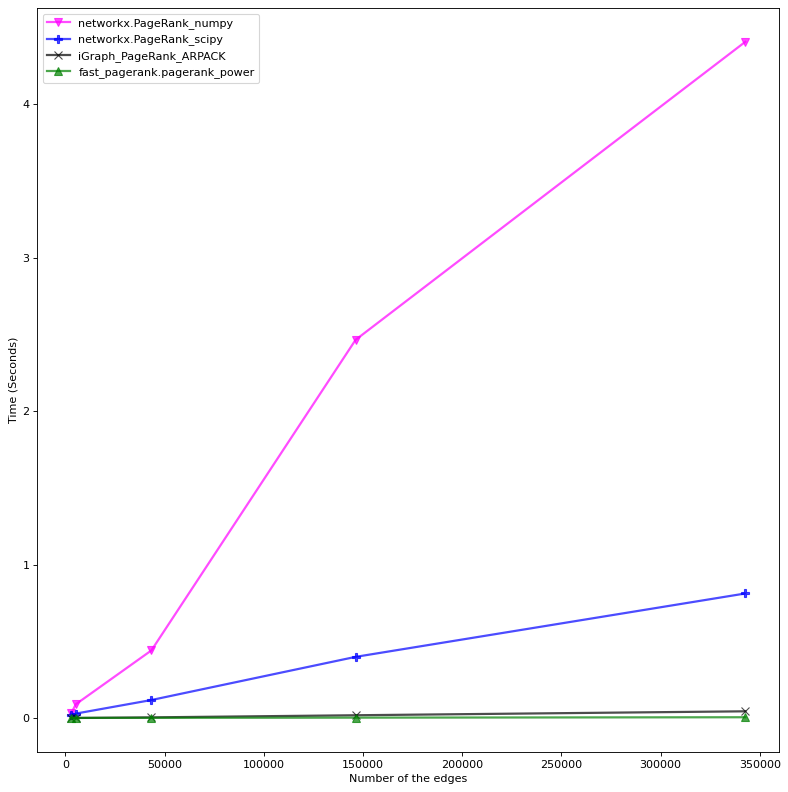

In [4]:
plt.ioff()
fig=plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')


plt.plot(comparison_table['Edges'], comparison_table['NetX (numpy)'],
         'v-', ms=8, lw=2, alpha=0.7, color='magenta',
         label='networkx.PageRank_numpy')

plt.plot(comparison_table['Edges'], comparison_table['NetX (scipy)'],
         'P-', ms=8, lw=2, alpha=0.7, color='blue',
         label='networkx.PageRank_scipy')

plt.plot(comparison_table['Edges'], comparison_table['iGraph'],
         'x-', ms=8, lw=2, alpha=0.7, color='black',
         label='iGraph_PageRank_ARPACK')
                          
plt.plot(comparison_table['Edges'], comparison_table['(fast) pagerank_power'],
         '^-', ms=8, lw=2, alpha=0.7, color='green',
         label='fast_pagerank.pagerank_power')


plt.xlabel('Number of the edges')
plt.ylabel('Time (Seconds)')


plt.tight_layout()
plt.legend(loc=2)
plt.savefig('pagerank_methods_comparison.png')
plt.show()